___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

___
## Parsing predownloaded pbf maps

In [3]:
import geopandas
from pyrosm import OSM

[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

<AxesSubplot:>

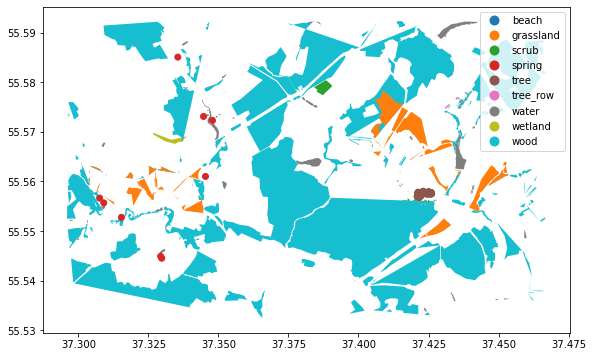

In [4]:
osm = OSM("maps/valuevo.osm.pbf") #possible use of boundary_box parameter and download whole world
# custom_filter = {"natural" : True}
# natural = osm.get_data_by_custom_criteria(custom_filter = custom_filter, keep_nodes = True)
natural = osm.get_natural(extra_attributes=['nodes'])
natural.plot(column='natural', legend=True, figsize=(10,6))
# print("\nAdditional attributes in the 'tags': \n", natural.tags.unique())

In [5]:
natural.tail(2)

,id,changeset,lon,tags,lat,timestamp,version,natural,geometry,osm_type,water,wetland
295,507346879,0.0,NaN,"{""type"":""multipolygon""}",NaN,0,-1,wood,"MULTIPOLYGON (((37.39658 55.56861, 37.40027 55...",relation,None,NaN
296,1422051155,0.0,NaN,"{""type"":""multipolygon""}",NaN,0,-1,wood,"MULTIPOLYGON (((37.37494 55.57638, 37.36149 55...",relation,None,NaN


In [6]:
natural.geometry.type.unique()

array(['Point', 'Polygon', 'LineString', 'MultiLineString',
       'MultiPolygon'], dtype=object)

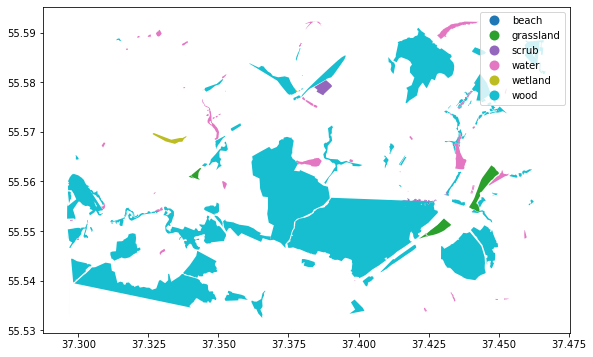

In [7]:
polygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'Polygon']
polygons.plot(column='natural', legend=True, figsize=(10,6));

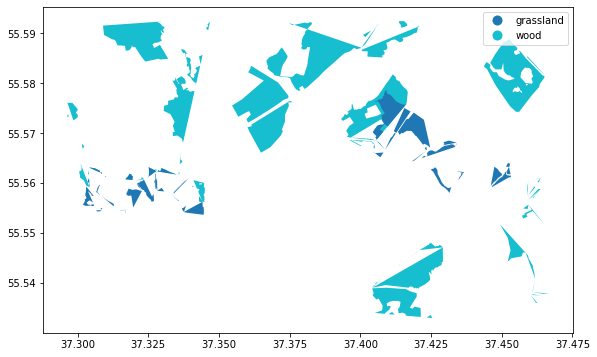

In [26]:
multipolygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'MultiPolygon']
multipolygons.plot(column='natural', legend=True, figsize=(10,6));

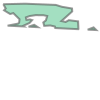

In [31]:
multipolygons.iloc[2,1]

___
## Building a convex hull

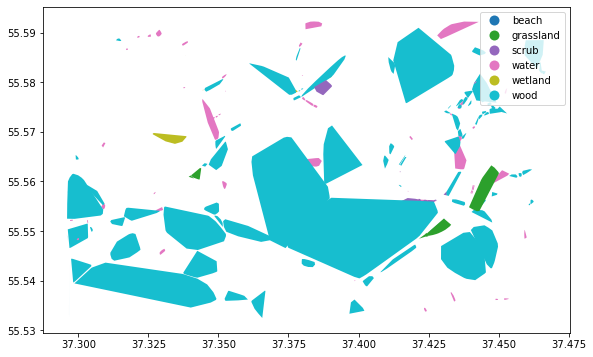

In [8]:
polygons.geometry = polygons.geometry.convex_hull # check for efficiency and rewrite if needed
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Find optimal pair

In [9]:
import numpy as np
import math

def vec(a, b):
    return np.array(b) - np.array(a)

def mod(v):
    return (v[0]**2 + v[1]**2)**0.5

def angle(a, b, c):
    if (a == b).all() or (a == c).all() or (b == c).all():
        return 1
    return math.acos(np.dot(vec(b,a), vec(b,c)) / (mod(vec(b, a)) * mod(vec(b, c))))

def point_in_angle(p, a, b, c):
    delta = 0.00000001
    return math.fabs(angle(a, b, c) - angle (a, b, p) - angle(p, b, c)) < delta

In [10]:
# o(N * n)
def find_pair(point, left_border, right_border, coord):
    n = len(coord) - 1
    # optimize list work
    b = [1 for i in range(n)]
    count = 0
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            b[i] = 0
            count += 1
    if count == 0:
        return 1
    if count == n:
        # print("Point inside a polygon")
        return 1
    if b[0] == 1:
        start = b.index(0, 1)
        if b[n-1] == 0:
            end = n-1
        else:
            end = b.index(1, start + 1)
            end -= 1
    if b[0] == 0:
        start = b.index(1, 1)
        start -= 1
        if b[n-1] == 1:
            end = n
        else:
            end = b.index(0, start + 1)
    return (start, end)

In [11]:
# o(N)
def find_pair2(point, left_border, right_border, coord):
    n = len(coord) - 1
    begin = end = -1
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            if i == 0:
                start_zero = True
            if begin == -1 and not start_zero:
                begin = i
            if start_zero and end != -1:
                begin = i
                return (begin, end)
            if not start_zero and i == n - 1:
                end = n - 1
                return (begin, end)
        else:
            if i == 0:
                start_zero = False
            if begin != -1 and not start_zero:
                end = (i-1)%n
                return (begin, end)
            if start_zero and end == -1:
                end = (i-1)%n
            if start_zero and i == n - 1:
                begin = n
                return (begin, end)
    return 1

___
## Build a graph

In [12]:
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import mplleaflet
import networkx as nx

In [13]:
import pandas as pd
import rdp

epsilon = 0.001

def get_coord(poly):
    return rdp.rdp(np.array(mapping(poly)['coordinates'][0]), epsilon=epsilon)

def get_centroid(poly):
    return Polygon(poly).centroid

polygons = pd.DataFrame(polygons)
polygons['centroid'] = polygons.geometry.apply(get_centroid)
polygons.geometry = polygons.geometry.apply(get_coord)
polygons = polygons.reset_index().rename(columns={'geometry' : 'coords'}).drop(columns='index')
polygons.head()

,natural,coords,centroid
0,water,"[[37.3846279, 55.562994], [37.3774899, 55.5640...",POINT (37.38256586814534 55.5638633062394)
1,wood,"[[37.3836755, 55.5427088], [37.3798131, 55.544...",POINT (37.38197036938395 55.54349386187526)
2,water,"[[37.3520944, 55.5584858], [37.3513876, 55.560...",POINT (37.35213303704695 55.55934500506783)
3,wood,"[[37.4432891, 55.5854393], [37.4405084, 55.586...",POINT (37.44288776792962 55.5862082912586)
4,water,"[[37.3976756, 55.5638538], [37.3967207, 55.564...",POINT (37.3973815371014 55.56417017525649)


In [24]:
view_angle = 15

def build_graph(polygons, plot=None):
    poly_number = polygons.shape[0]
    fig = plt.figure()
    G = nx.MultiGraph(crs='EPSG:4326')
    max_poly_len = 10000 # for graph indexing

    for i in range(poly_number):

        if plot:
            x_arr, y_arr = (polygons.iloc[i,1]).exterior.coords.xy
            plt.plot(x_arr, y_arr);

        coords_1 = polygons.coords[i]
        for j in range(poly_number):
            if j == i:
                continue

            coords_2 = polygons.coords[j]
            n = len(coords_2) - 1
            for k in range(n):
                point = coords_2[k]
                left_border = coords_2[(k-1)%n]
                right_border = coords_2[(k+1)%n]
                pair = find_pair2(point, left_border, right_border, coords_1)
                if pair == 1:
                    continue
                G.add_node(j * max_poly_len + k, x=point[0], y=point[1])
                
                delta_angle = view_angle * math.pi / 180
                if angle(coords_1[pair[0]], point, coords_1[pair[1]]) < delta_angle:
                    x = polygons.centroid[i].x
                    y = polygons.centroid[i].y
                    G.add_node(i * max_poly_len - 1, x = x, y = y)
                    G.add_edge(i * max_poly_len - 1, j * max_poly_len + k)
                    if plot:
                        plt.plot([point[0], x], [point[1], y]);
                    continue

                x1 = coords_1[pair[0]][0]
                x2 = coords_1[pair[1]][0]
                y1 = coords_1[pair[0]][1]
                y2 = coords_1[pair[1]][1]
                G.add_node(i * max_poly_len + pair[0], x = x1, y = y1)
                G.add_node(i * max_poly_len + pair[1], x = x2, y = y2)
                G.add_edge(i * max_poly_len + pair[0], j * max_poly_len + k)
                G.add_edge(i * max_poly_len + pair[1], j * max_poly_len + k)

                if plot:
                    plt.plot([point[0], x1], [point[1], y1]);
                    plt.plot([point[0], x2], [point[1], y2]);

    return G, fig

In [25]:
%%time
G, fig = build_graph(polygons)
# mplleaflet.display(fig=fig)

CPU times: user 29.3 s, sys: 83 ms, total: 29.4 s
Wall time: 36.2 s


<Figure size 432x288 with 0 Axes>

In [22]:
G.number_of_edges()

17166

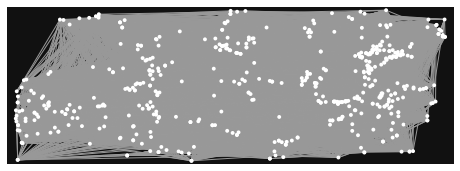

In [23]:
import osmnx as ox
ox.plot_graph(G);

___
Problems:
- Uncovered crosses
- Inside polygon no nodes and edges
- Only polygons computed